In [0]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 59kB/s 


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
import os
os.chdir("drive/DCGAN")

In [0]:
!ls

Untitled0.ipynb


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

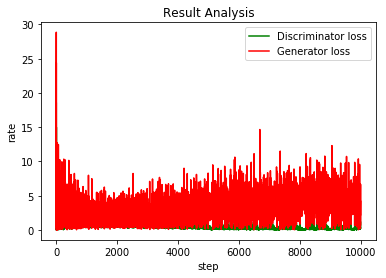

In [0]:
"""
1. data provider
    a image data 
    b. random vector
2. build compute graph
    a. generator 
    b. discriminator
    c. dcgan
       connect g and d 
       define loss
       define train_op
3. training process

"""
import  os
import  sys
import  tensorflow as  tf
from tensorflow import  logging
from tensorflow import  gfile
import pprint
import pickle
import numpy as np
import random
import math
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data/',one_hot = True)

output_dir = './local_run'
if not gfile.Exists(output_dir):
    gfile.MakeDirs(output_dir)

def get_default_params():
    return tf.contrib.training.HParams(
        z_dim =100,
        init_conv_size =4,
        g_channels = [128,64,32,1],
        d_channels = [32,64,128,256],
        batch_size = 128,
        learning_rate =0.002,
        beta1 =0.5 ,
        img_size = 32,
    )

hps = get_default_params()

class Mnistdata (object):
    def __init__(self,mnist_train,z_dim,img_size ):
        self._data = mnist_train
        self._example_num = len(self._data)
        self._z_data = np.random.standard_normal(
            (self._example_num,z_dim))
        self._indicator = 0
        self._resize_mnist_img(img_size)
        self._random_shuffle()

    def _random_shuffle(self):
        p = np.random.permutation(self._example_num)
        self._z_data = self._z_data[p]
        self._data = self._data[p]

    def _resize_mnist_img(self,img_size):
        """resize mnist image to goal imf_size
        1 . numpy -> PLY img
        2 . PLY img -> resize
        3 . PLY img -> numpy
        
        """
        data = np.asarray(self._data *255,np.uint8)
        # [example_num,784] -> [example_num,28,28]
        data = data.reshape((self._example_num,28,28))
        new_data = []
        for i in range(self._example_num):
               img = data[i]
               img = Image.fromarray(img)
               img = img.resize((img_size,img_size))
               img = np.asarray(img)
               img = img.reshape((img_size,img_size,1))
               new_data.append(img)
        new_data = np.asarray(new_data,dtype = np.float32)
        new_data = new_data / 127.5 -1

        self._data = new_data

    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self._example_num:
            self._random_shuffle()
            self._indicator = 0
            end_indicator = self._indicator + batch_size
        assert end_indicator < self._example_num
        batch_data = self._data[self._indicator: end_indicator]
        batch_z = self._z_data[self._indicator: end_indicator]
        self._indicator = end_indicator
        return batch_data, batch_z

mnist_data = Mnistdata(mnist.train.images ,hps.z_dim ,hps.img_size)

def conv2d_transpose(inputs,out_channel,name,
                     training,with_bn_relu = True):
    """wrapper of conv2d transpose"""
    with tf.variable_scope(name):
        conv2d_trans = tf.layers.conv2d_transpose(inputs,
                                                  out_channel,
                                                  [5,5],
                                                  strides = (2,2),
                                                  padding = 'SAME')
        if with_bn_relu:
            bn = tf.layers.batch_normalization(conv2d_trans,
                                               training = training)
            relu = tf.nn.relu(bn)
            return relu
        else:
            return conv2d_trans

def conv2d(inputs, out_channel, name, training):
    def leaky_relu(x,leak = 0.2, name =''):
        return tf.maximum(x, x*leak,name=name)
    with tf.variable_scope(name):
        conv2d_output = tf.layers.conv2d(inputs,
                                         out_channel,
                                         [5,5],
                                         strides = (2,2),
                                         padding = 'SAME')
        bn = tf.layers.batch_normalization(conv2d_output,
                                           training = training)
        return leaky_relu(bn,name= 'outputs')

class Generator(object):
    def __init__(self,channels,init_conv_size):
        self._channels = channels
        self._init_conv_size = init_conv_size
        self._reuse = False

    def __call__(self, inputs, training):
        inputs = tf.convert_to_tensor(inputs)
        with tf.variable_scope('generator',reuse = self._reuse):
            """
            random_vector -> fc -> self._channels[0] * init_conv_size**2
            -> reshape -> [init_conv_size,init_conv_size, channels[0]]
             
            """
            with tf.variable_scope('inputs_conv'):
                fc = tf.layers.dense(
                    inputs,
                    self._channels[0] *self._init_conv_size *self._init_conv_size)
                conv0 = tf.reshape(fc,
                                   [-1,
                                    self._init_conv_size,
                                    self._init_conv_size,
                                    self._channels[0]])
                bn0 = tf.layers.batch_normalization(conv0,training = training)
                relu0= tf.nn.relu(bn0)
                deconv_inputs = relu0
                for i in range(1,len(self._channels)):
                    with_bn_relu = ( i != len(self._channels)-1 )
                    deconv_inputs = conv2d_transpose(
                        deconv_inputs,
                        self._channels[i],
                        "deconv-%d" % i,
                        training,
                        with_bn_relu)
                img_inputs = deconv_inputs
                with tf.variable_scope('generate_imgs'):
                    imgs = tf.tanh(img_inputs,name='imgs')
        self._reuse = True
        self.variables = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES,
            scope = 'generator')
        return imgs

class Discriminator(object):
    def __init__(self, channels):
        self._channels = channels
        self._reuse = False

    def __call__(self, inputs, training):
        inputs = tf.convert_to_tensor(inputs,dtype=tf.float32)

        conv_inputs = inputs
        with tf.variable_scope('discriminator',reuse = self._reuse):
            for i in range(len(self._channels)):
                conv_inputs = conv2d(conv_inputs,
                                     self._channels[i],
                                     'conv-%d' %i,
                                     training)
            fc_inputs = conv_inputs
            with tf.variable_scope('fc'):
                flatten = tf.layers.flatten(fc_inputs)
                logits = tf.layers.dense(flatten,2,name = 'logits')
        self._reuse = True
        self.variables = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES,
            scope = 'discriminator')
        return logits


class DCGAN(object):
    def __init__(self, hps):
        g_channels = hps.g_channels
        d_channels = hps.d_channels

        self._batch_size = hps.batch_size
        self._init_conv_size = hps.init_conv_size
        self._z_dim = hps.z_dim
        self._img_size = hps.img_size

        self._generator = Generator(g_channels,self._init_conv_size)
        self._discriminator = Discriminator(d_channels)

    def build (self):
        """ Builds the whole compute graph"""
        self._z_placeholder = tf.placeholder(
             tf.float32,(self._batch_size,self._z_dim))
        self._img_placeholder = tf.placeholder(
             tf.float32,
             (self._batch_size,self._img_size,self._img_size,1))

        generated_imgs = self._generator(
             self._z_placeholder,training = True )

        fake_img_logits = self._discriminator(
             generated_imgs,training = True)
        real_img_logits = self._discriminator(
             self._img_placeholder,training = True)

        loss_on_fake_to_real = tf.reduce_mean(
             tf.nn.sparse_softmax_cross_entropy_with_logits(
                 labels = tf.ones([self._batch_size],dtype = tf.int64),
                   logits = fake_img_logits))
        loss_on_fake_to_fake = tf.reduce_mean(
             tf.nn.sparse_softmax_cross_entropy_with_logits(
                 labels = tf.zeros([self._batch_size],dtype = tf.int64),
                   logits = fake_img_logits))
        loss_on_real_to_real = tf.reduce_mean(
             tf.nn.sparse_softmax_cross_entropy_with_logits(
                 labels = tf.ones([self._batch_size],dtype = tf.int64),
                   logits = real_img_logits))
        tf.add_to_collection('g_losses',loss_on_fake_to_real)
        tf.add_to_collection('d_losses',loss_on_fake_to_fake)
        tf.add_to_collection('d_losses',loss_on_real_to_real)
        loss = {
              'g': tf.add_n(tf.get_collection('g_losses'),
                            name = 'total_g_loss'),
              'd': tf.add_n(tf.get_collection('d_losses'),
                            name = 'total_d_loss')
         }
        return (self._z_placeholder,self._img_placeholder,generated_imgs,loss)

    def build_train_op(self,losses,learning_rate,beta1):
          """Builds train op ,should be called after build is called."""
          g_opt = tf.train.AdamOptimizer(
                   learning_rate = learning_rate,
                    beta1 = beta1)
          d_opt = tf.train.AdamOptimizer(
                   learning_rate = learning_rate,
                    beta1 = beta1)

          g_opt_op = g_opt.minimize(
              losses['g'],var_list = self._generator.variables)
          d_opt_op = d_opt.minimize(
              losses['d'],var_list = self._discriminator.variables)
          with tf.control_dependencies([g_opt_op,d_opt_op]):
              return tf.no_op(name = 'train')


dcgan = DCGAN(hps)
z_placeholder,img_placeholder,generated_imgs,losses = dcgan.build()
train_op = dcgan.build_train_op(losses,hps.learning_rate,hps.beta1)

def combine_imgs(batch_imgs,img_size,rows= 8 ,cols = 16):
    """combines small images in a batch into a big picture"""
     #batch_img: [batch_size,img_size,img_size,1]
    result_big_img= []
    for i in range(rows):
          row_imgs = []
          for j in range(cols):
              img = batch_imgs[ cols * i +j]
              img = img.reshape((img_size,img_size))
              img = (img + 1) * 127.5
              row_imgs.append(img)
          row_imgs = np.hstack(row_imgs)
          result_big_img.append(row_imgs)

    result_big_img = np.vstack(result_big_img)
    result_big_img = np.asarray(result_big_img,np.uint8)
    result_big_img = Image.fromarray(result_big_img)
    return result_big_img

init_op = tf.global_variables_initializer()
train_steps = 10000
Dis_losses= []
Gen_losses=[]
with tf.Session() as sess:
    sess.run(init_op)
    for step in range(train_steps):
        batch_imgs,batch_z = mnist_data.next_batch(hps.batch_size)
        fetches = [train_op,losses['g'],losses['d']]
        should_sample = (step +1 ) % 50 == 0
        if should_sample:
            fetches +=[generated_imgs]
        output_values = sess.run(fetches,
                                 feed_dict = {
                                     z_placeholder:batch_z,
                                     img_placeholder:batch_imgs
                                 })
        _, g_loss_val,d_loss_val = output_values[0:3]
        Dis_losses.append(d_loss_val)
        Gen_losses.append(g_loss_val)
        logging.info('step: %4d, g_loss: %4.3f,d_loss:%4.3f' %(step,g_loss_val,d_loss_val))
        if should_sample:
            gen_imgs_val = output_values[3]
            gen_img_path = os.path.join(output_dir,'%05d-gen.jpg' % (step+1))
            gt_img_path = os.path.join(output_dir,'%05d-gt.jpg' % (step +1))
            gen_img = combine_imgs(gen_imgs_val,hps.img_size)
            gt_img = combine_imgs(batch_imgs,hps.img_size)
            gen_img.save(gen_img_path)
            gt_img.save(gt_img_path)


plt.title('Result Analysis')
plt.plot(Dis_losses, color='green', label='Discriminator loss')
plt.plot(Gen_losses, color='red', label='Generator loss')

plt.legend()
plt.xlabel('step')
plt.ylabel('rate')
plt.savefig("loss.jpg")
plt.show()


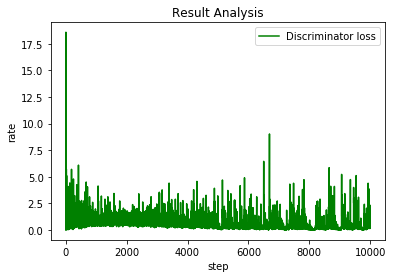

In [0]:
plt.title('Result Analysis')
plt.plot(Dis_losses, color='green', label='Discriminator loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('rate')
plt.savefig(" D_loss.jpg")
plt.show()


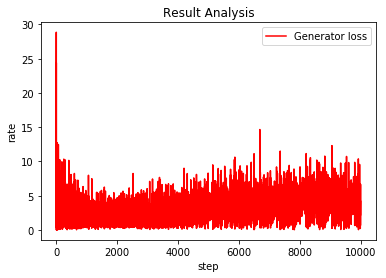

In [0]:
plt.title('Result Analysis')
plt.plot(Gen_losses, color='red', label='Generator loss')

plt.legend()
plt.xlabel('step')
plt.ylabel('rate')
plt.savefig("G_loss.jpg")
plt.show()